# DeutscheWelle Data Engineering Challenge

9.05.2023


# Task 1

## Connect via Gmail API



In [1]:
## Script that dowloads emails from gmail inbox

## from https://developers.google.com/gmail/api/reference/rest/v1/users.messages.attachments/get 
# # Method to download email attachments from gmail api
##
# userId dwdechallenge@gmail.com / me (authenticated user)
# messageId 
# id  2022-09-15-23-04-08-EDT-Historical-Report-ENTRFacebook-2022-06-16--2022-09-16.csv 
#GET https://gmail.googleapis.com/gmail/v1/users/{userId}/messages/{messageId}/attachments/{id}

In [2]:
from googleapiclient.discovery import build
from google.oauth2.credentials import Credentials
from googleapiclient.errors import HttpError
import base64
import os
import time
import sys 

# Import functions from source folder
sys.path.append('../src/') 
from api_functions import *


In [3]:
# If modifying these scopes, delete the file token.json.
SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']
creds = Credentials.from_authorized_user_file('../token.json', SCOPES)
service = build('gmail', 'v1', credentials=creds)

## search for emails with 'report' in the attachment name
query_string='filename:report*csv' #find all the email with attachment in csv format containing 'report' in their name
# other possible queries
#query_string='report' # all email with report in subject/body text
#query_string='has:attachment' # all email with attachments
email_messages = search_email(service, query_string,['INBOX'])
try:
    path = os.path.join('../', 'data/downloaded')
    os.mkdir(path)
except OSError as error:
    print(error) 
save_location='../data/downloaded'
## download attachments for found emails 

for email_message in email_messages:
    #print(email_message['id'])
    #187ffb2fbf3c1bc5
    messageDetail = get_message_detail(service,email_message['id'],msg_format='full',metadata_headers=['parts'])
    #print(messageDetail)
    messageDetailPayload = messageDetail.get('payload')

    if 'parts' in messageDetailPayload:
        for msgPayload in messageDetailPayload['parts']:
            file_name = msgPayload['filename']
            body=msgPayload['body']

            if 'attachmentId' in body:
                attachment_id = body['attachmentId']
                attachment_content= get_file_data(service,email_message['id'],attachment_id,file_name,save_location)
                print(file_name)
                
                #with open(os.path.join(save_location + '/' 'Downloaded_files' + '/' + file_name),'wb') as _f:
                with open(os.path.join(save_location + '/' + file_name),'wb') as _f:
                    _f.write(attachment_content)
                    print(f'File {file_name} is saved at {save_location}')
    time.sleep(0.5)
    #break

[Errno 17] File exists: '../data/downloaded'
2022-09-15-23-04-08-EDT-Historical-Report-ENTRFacebook-2022-06-16--2022-09-16.csv
File 2022-09-15-23-04-08-EDT-Historical-Report-ENTRFacebook-2022-06-16--2022-09-16.csv is saved at ../data/downloaded
2022-09-16-23-04-01-EDT-Historical-Report-ENTRFacebook-2022-06-17--2022-09-17.csv
File 2022-09-16-23-04-01-EDT-Historical-Report-ENTRFacebook-2022-06-17--2022-09-17.csv is saved at ../data/downloaded
2022-09-17-23-04-42-EDT-Historical-Report-ENTRFacebook-2022-06-18--2022-09-18.csv
File 2022-09-17-23-04-42-EDT-Historical-Report-ENTRFacebook-2022-06-18--2022-09-18.csv is saved at ../data/downloaded
2022-09-18-23-03-32-EDT-Historical-Report-ENTRFacebook-2022-06-19--2022-09-19.csv
File 2022-09-18-23-03-32-EDT-Historical-Report-ENTRFacebook-2022-06-19--2022-09-19.csv is saved at ../data/downloaded
2022-09-20-23-03-35-EDT-Historical-Report-ENTRFacebook-2022-06-21--2022-09-21.csv
File 2022-09-20-23-03-35-EDT-Historical-Report-ENTRFacebook-2022-06-21--2

## Read the data from the files and upload them to the postgres database.

In [4]:
import pandas as pd
import psycopg2
import os
import glob
import sys

# Import functions from source folder
sys.path.append('../src/') 
from postgres_functions import *

In [5]:
#downloaded report .csv files

daily_repo_filepath='../data/downloaded/' # downloaded files via API
files=glob.glob(os.path.join(daily_repo_filepath,"*.csv"))
files

['../data/downloaded/2022-09-18-23-03-32-EDT-Historical-Report-ENTRFacebook-2022-06-19--2022-09-19.csv',
 '../data/downloaded/2022-09-16-23-04-01-EDT-Historical-Report-ENTRFacebook-2022-06-17--2022-09-17.csv',
 '../data/downloaded/2022-09-21-23-04-26-EDT-Historical-Report-ENTRFacebook-2022-06-22--2022-09-22.csv',
 '../data/downloaded/2022-09-17-23-04-42-EDT-Historical-Report-ENTRFacebook-2022-06-18--2022-09-18.csv',
 '../data/downloaded/2022-09-20-23-03-35-EDT-Historical-Report-ENTRFacebook-2022-06-21--2022-09-21.csv',
 '../data/downloaded/2022-09-15-23-04-08-EDT-Historical-Report-ENTRFacebook-2022-06-16--2022-09-16.csv',
 '../data/downloaded/2022-09-23-23-04-15-EDT-Historical-Report-ENTRFacebook-2022-06-24--2022-09-24.csv']

In [6]:
#check the data with pandas
data = pd.read_csv(files[0])
data.head()

,Page Name,User Name,Facebook Id,Page Category,Page Admin Top Country,Page Description,Page Created,Likes at Posting,Followers at Posting,Post Created,...,Message,Link,Final Link,Image Text,Link Text,Description,Sponsor Id,Sponsor Name,Sponsor Category,Overperforming Score
0,Onet Styl Życia,onetstylzycia,372341662829366,NEWS_SITE,PL,Najbardziej stylowy serwis w Polsce!,2012-06-05 16:57:21,558890,563792,2022-09-18 21:00:26 EDT,...,Wyrwał: w rękach Rosjan jest ok. 17 proc. tery...,https://www.facebook.com/onetstylzycia/videos/...,NaN,NaN,"""To jest przełom w wojnie w Ukrainie, zdobywam...",NaN,NaN,NaN,NaN,-0.89
1,DW News,deutschewellenews,100064359716848,NEWS_SITE,DE,Follow us for trustworthy news and analysis fr...,2008-08-26 12:26:42,2664421,3150873,2022-09-18 20:12:16 EDT,...,Every year 400 million tonnes of plastic are p...,https://www.facebook.com/deutschewellenews/vid...,NaN,NaN,Highlighting the plastic waste problem,NaN,NaN,NaN,NaN,-3.29
2,DW Euromaxx,dw.euromaxx,211745678846355,BROADCASTING_MEDIA_PRODUCTION,DE,Euromaxx is made for those who love European #...,2011-05-17 14:08:01,501640,756194,2022-09-18 19:15:16 EDT,...,"🥚🥔 In Spain, they're eaten for breakfast, lunc...",https://www.facebook.com/dw.euromaxx/videos/47...,NaN,NaN,The Secrets Behind the Traditional Spanish Tor...,NaN,NaN,NaN,NaN,1.01
3,Onet Wiadomości,OnetWiadomosci,56024223012,NEWS_SITE,PL,"Jeśli macie jakieś uwagi, chcecie pokazać, jak...",2009-01-13 10:54:16,533859,625613,2022-09-18 19:00:20 EDT,...,"""Staram się, aby to nie była zwykła relacja z ...",https://www.facebook.com/OnetWiadomosci/videos...,NaN,NaN,"""Robię filmiki komediowe, podróżnicze, ciekawo...",NaN,NaN,NaN,NaN,-5.17
4,Konbini news,konbininews,183081005507412,MEDIA_NEWS_COMPANY,FR,Society & Politics by Konbini,2017-01-30 10:03:14,722701,1546605,2022-09-18 16:05:01 EDT,...,"Algorithme, limites entre vie pro et perso, me...",https://buff.ly/3BHd46t,https://www.konbini.com/videos/enjoyphoenix-de...,NaN,EnjoyPhoenix dévoile les réalités du métier de...,"Algorithme, limites entre vie pro et perso, me...",NaN,NaN,NaN,-4.72


In [7]:
# connect to postgres database
#parameters
param_dic = {
    "host"      : "localhost",
    "database"  : "postgres",
    "user"      : "postgres",
}

In [8]:
#create postgres database

# column names from pandas dataframe csv file
cols=','.join([column.replace(" ", "_").replace("?","").lower() + str(' VARCHAR') for column in data.columns.values])

#name of a new postgres database 
new_table='table103'

#query=("DROP TABLE IF EXISTS %s;"%(new_table))
query=("CREATE TABLE IF NOT EXISTS %s(%s)" %(new_table,(cols))) 

conn = connect(param_dic)
execute_query(conn, query)
#create_postgres(data,table)

#name of the postgres database to upload data
table=new_table

#upload data from csv files to postreg database
[upload_csv_to_postgres(table,files) for file in files]

Connecting to the PostgreSQL database...
Connection successful
Connecting to the PostgreSQL database...
Connection successful
Connecting to the PostgreSQL database...
Connection successful
Connecting to the PostgreSQL database...
Connection successful
Connecting to the PostgreSQL database...
Connection successful
Connecting to the PostgreSQL database...
Connection successful
Connecting to the PostgreSQL database...
Connection successful
Connecting to the PostgreSQL database...
Connection successful
Connecting to the PostgreSQL database...
Connection successful


[None, None, None, None, None, None, None]

In [9]:
conn = connect(param_dic)
execute_query(conn, 'SELECT Page_Name User_Name FROM new_table')

Connecting to the PostgreSQL database...
Connection successful
Connecting to the PostgreSQL database...
Connection successful


[('\ufeffPage Name',),
 ('Onet Styl Życia',),
 ('DW News',),
 ('DW Euromaxx',),
 ('Onet Wiadomości',),
 ('Konbini news',),
 ('Onet Sport',),
 ('G4 Media',),
 ('Onet Sport',),
 ('Noizz Food',),
 ('ENTR ro',),
 ('Noizz Food',),
 ('DW Bundesliga Kick off',),
 ('DW News',),
 ('DW Euromaxx',),
 ('ENTR ro',),
 ('Noizz Food',),
 ('DW Euromaxx (Deutsch)',),
 ('DW Travel',),
 ('DW Culture',),
 ('DW Business',),
 ('DW Travel',),
 ('DW Global Ideas',),
 ('DW Euromaxx',),
 ('DW Stories',),
 ('DW Culture',),
 ('Onet Sport',),
 ('DW Română',),
 ('DW Music',),
 ('Noizz Food',),
 ('DW Euromaxx (Deutsch)',),
 ('Onet Sport',),
 ('DW Travel',),
 ('RFI Romania',),
 ('FRANCE 24 English',),
 ('Onet Sport',),
 ('DW Culture',),
 ('Noizz Food',),
 ('NOIZZ.pl',),
 ('RTP',),
 ('DW Travel',),
 ('DW Reise',),
 ('DW Euromaxx',),
 ('Onet',),
 ('Onet Kultura',),
 ('ENTR fr',),
 ('DW Euromaxx (Deutsch)',),
 ('Noizz Food',),
 ('DW Music',),
 ('DW Culture',),
 ('DW Global Ideas',),
 ('DW Română',),
 ('ENTR en',),
 ('Noi

### SQL queries used to create tables the data are in SQL_query

## EDA on facebook dataset

In [10]:

## create tables 
path_preproc='/Users/anya/SCIENCE/DW_Challenge/data/processed/'
video_table=pd.read_csv(path_preproc+'video_statistics_table.csv')
video_table

,page_admin_top_country,video_share_status,total_views,video_length
0,Page Admin Top Country,Video Share Status,Total Views,Video Length
1,PL,crosspost,14,00:04:30
2,DE,owned,599,00:01:13
3,DE,owned,1498,00:05:04
4,PL,crosspost,243,00:05:23
...,...,...,...,...
346894,PL,crosspost,1659,02:01:30
346895,PL,crosspost,1299,02:01:30
346896,FR,crosspost,1122,00:12:29
346897,PL,crosspost,1263,00:04:08


In [11]:
video_table['video_share_status'].unique()

#remove Video Share Status from the rows
df = video_table.drop(video_table[video_table['video_share_status'] == 'Video Share Status'].index)
#remove nan values from dataframe
df_new = df.dropna(axis=0)

df_new.head()

,page_admin_top_country,video_share_status,total_views,video_length
1,PL,crosspost,14,00:04:30
2,DE,owned,599,00:01:13
3,DE,owned,1498,00:05:04
4,PL,crosspost,243,00:05:23
6,PL,crosspost,7138,00:05:00


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 346850 entries, 1 to 346898
Data columns (total 4 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   page_admin_top_country  346850 non-null  object
 1   video_share_status      342790 non-null  object
 2   total_views             346850 non-null  object
 3   video_length            342790 non-null  object
dtypes: object(4)
memory usage: 13.2+ MB


In [13]:
df.describe()

,page_admin_top_country,video_share_status,total_views,video_length
count,346850,342790,346850,342790
unique,5,3,8170,1000
top,DE,crosspost,0,00:00:59
freq,128597,184660,4158,6755


In [14]:
df.isnull().sum()

page_admin_top_country       0
video_share_status        4060
total_views                  0
video_length              4060
dtype: int64

In [15]:
df['page_admin_top_country'].value_counts()

page_admin_top_country
DE    128597
FR    111937
PL     93205
PT     12327
RO       784
Name: count, dtype: int64

In [16]:
print(df_new['video_share_status'].unique())
print(df_new['page_admin_top_country'].unique())

['crosspost' 'owned' 'share']
['PL' 'DE' 'RO' 'FR' 'PT']


<Axes: xlabel='page_admin_top_country', ylabel='count'>

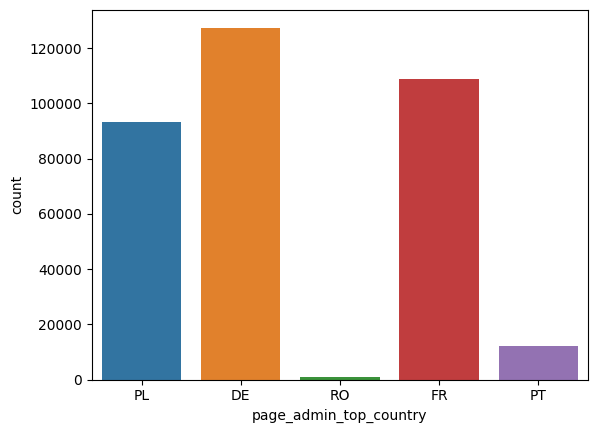

In [17]:
import seaborn as sns
# plot showing that most of the pages are created by admins from Germany
sns.countplot(x=df_new['page_admin_top_country'])

<Axes: xlabel='video_share_status', ylabel='count'>

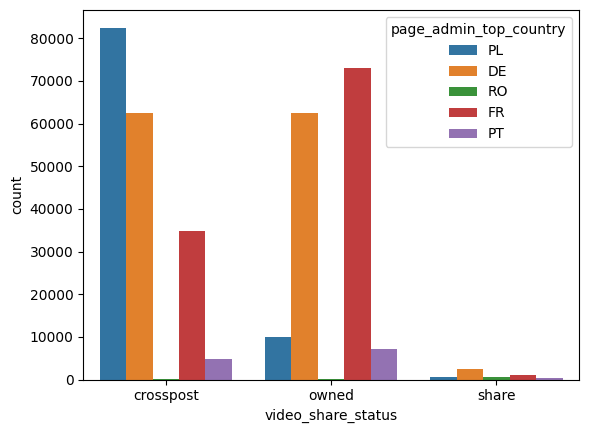

In [18]:
# page admins in Poland tend to crosspost video content
# while french prefer to post their own video content
# german admins crosspost and share their own video content in equal proportions
# 
sns.countplot(hue=df_new['page_admin_top_country'],x=df_new['video_share_status'])

In [19]:
df_new.video_length
df_new.video_length_timedelta = pd.to_timedelta(df_new.video_length)
df_new.video_length_datetime = pd.to_datetime(df_new.video_length)


/var/folders/9g/1hjl7qb93jx5v6xrj38t_s7r0000gn/T/ipykernel_35538/281454558.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_new.video_length_timedelta = pd.to_timedelta(df_new.video_length)
/var/folders/9g/1hjl7qb93jx5v6xrj38t_s7r0000gn/T/ipykernel_35538/281454558.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_new.video_length_datetime = pd.to_datetime(df_new.video_length)
/var/folders/9g/1hjl7qb93jx5v6xrj38t_s7r0000gn/T/ipykernel_35538/281454558.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_new.video_length_datetime = pd.to_datetime(df_new.video_length)


# Task 2

#### Have a look at the dwh_dl_facebook_post_insights.csv. You will find there 3 rows for seperate posts. Import the csv to a database table

In [23]:
# reading in the csv file
path_insights='/Users/anya/SCIENCE/DW_Challenge/data/external/Junior_DE_Task/'
db_insights=pd.read_csv(path_insights+'dwh_dl_facebook_post_insights.csv')
db_insights

,insights_created_date,post_activity,post_activity_by_action_type,post_activity_by_action_type_unique,post_activity_unique,post_clicks,post_clicks_by_type,post_clicks_by_type_unique,post_clicks_unique,post_engaged_fan,...,post_video_views_autoplayed,post_video_views_by_distribution_type,post_video_views_clicked_to_play,post_video_views_organic,post_video_views_organic_unique,post_video_views_paid,post_video_views_paid_unique,post_video_views_sound_on,post_video_views_unique,period
0,2019-09-29,67,"{""share"": 6, ""like"": 56, ""comment"": 5}","{""share"": 5, ""like"": 56, ""comment"": 5}",65,384,"{""video play"": 307, ""other clicks"": 71, ""link ...","{""video play"": 303, ""other clicks"": 60, ""link ...",355,31,...,8074,"{""page_owned"": 8264, ""shared"": 48}",238,218,204,8094,7284,1445,7487,lifetime
1,2019-09-29,65,"{""share"": 5, ""like"": 58, ""comment"": 2}","{""share"": 5, ""like"": 58, ""comment"": 2}",61,352,"{""video play"": 265, ""other clicks"": 85}","{""video play"": 265, ""other clicks"": 71}",323,34,...,4467,"{""page_owned"": 4544, ""shared"": 143}",220,269,245,4418,4142,1391,4399,lifetime
2,2019-09-29,93,"{""share"": 9, ""like"": 84}","{""share"": 8, ""like"": 82}",87,327,"{""video play"": 272, ""other clicks"": 53}","{""video play"": 259, ""other clicks"": 48}",303,38,...,5900,"{""shared"": 50, ""page_owned"": 6035}",185,140,116,5945,5445,955,5558,lifetime


In [24]:
# creating a new postgres database
table='insights_draft'
data=db_insights
files_ins=glob.glob(os.path.join(path_insights,"*.csv"))
#conn = connect(param_dic)
create_postgres(data,table)
# uploading data from csv file to the new database
upload_csv_to_postgres(table,files_ins)

Connecting to the PostgreSQL database...
Connection successful
Connecting to the PostgreSQL database...
Connection successful


In [25]:
cols_ins=cols=','.join([column.replace(" ", "_").replace("?","").lower() for column in data.columns.values])
cols_ins

'insights_created_date,post_activity,post_activity_by_action_type,post_activity_by_action_type_unique,post_activity_unique,post_clicks,post_clicks_by_type,post_clicks_by_type_unique,post_clicks_unique,post_engaged_fan,post_engaged_users,post_id,post_impressions,post_impressions_by_story_type,post_impressions_by_story_type_unique,post_impressions_fan,post_impressions_fan_paid,post_impressions_fan_paid_unique,post_impressions_fan_unique,post_impressions_nonviral,post_impressions_nonviral_unique,post_impressions_organic,post_impressions_organic_unique,post_impressions_paid,post_impressions_paid_unique,post_impressions_unique,post_impressions_viral,post_impressions_viral_unique,post_negative_feedback,post_negative_feedback_by_type,post_negative_feedback_by_type_unique,post_negative_feedback_unique,post_reactions_anger_total,post_reactions_by_type_total,post_reactions_haha_total,post_reactions_like_total,post_reactions_love_total,post_reactions_sorry_total,post_reactions_wow_total,post_vide

In [26]:
files_ins

['/Users/anya/SCIENCE/DW_Challenge/data/external/Junior_DE_Task/dwh_dl_facebook_post_insights.csv']

### Please write a SQL script to unpack the json in column post_video_view_time_by_age_bucket_and_gender in a new table, while preserving the other columns.

In [28]:
#Could not make queries for unpacking json work

# SELECT 
#    id, 
#    data::json->'name' as name,
#    data::json->'author' ->> 'last_name' as author
# FROM books;

In [29]:
conn = connect(param_dic)

sel_column='post_video_view_time_by_age_bucket_and_gender'
table='insights_draft'
execute_query(conn,'SELECT %s FROM %s'%(sel_column,table))

Connecting to the PostgreSQL database...
Connection successful
Connecting to the PostgreSQL database...
Connection successful


[('post_video_view_time_by_age_bucket_and_gender',),
 ('{"U.18-24": 92102, "U.25-34": 88501, "U.35-44": 211065, "U.45-54": 287, "U.55-64": 984, "U.65+": 1844, "F.13-17": 1784, "F.18-24": 1937557, "F.25-34": 639440, "F.35-44": 396171, "F.45-54": 246590, "F.55-64": 113451, "F.65+": 87312, "M.13-17": 96475, "M.18-24": 111569485, "M.25-34": 66971129, "M.35-44": 14400899, "M.45-54": 4410015, "M.55-64": 1509493, "M.65+": 2549387}',),
 ('{"U.18-24": 9397, "U.25-34": 11156, "U.35-44": 135338, "U.65+": 5311, "F.13-17": 3193, "F.18-24": 1874800, "F.25-34": 1199817, "F.35-44": 322278, "F.45-54": 304258, "F.55-64": 76856, "F.65+": 36672, "M.13-17": 109554, "M.18-24": 53686462, "M.25-34": 34117456, "M.35-44": 7100589, "M.45-54": 4654955, "M.55-64": 1369288, "M.65+": 1623651}',),
 ('{"U.18-24": 23693, "U.25-34": 260577, "U.35-44": 118480, "U.45-54": 33248, "U.55-64": 6300, "U.65+": 19956, "F.13-17": 23847, "F.18-24": 3580400, "F.25-34": 1657699, "F.35-44": 1190688, "F.45-54": 678030, "F.55-64": 3790

In [30]:
execute_query(conn,'SELECT %s FROM %s'%(sel_column,table))

Connecting to the PostgreSQL database...
Connection successful


[('post_video_view_time_by_age_bucket_and_gender',),
 ('{"U.18-24": 92102, "U.25-34": 88501, "U.35-44": 211065, "U.45-54": 287, "U.55-64": 984, "U.65+": 1844, "F.13-17": 1784, "F.18-24": 1937557, "F.25-34": 639440, "F.35-44": 396171, "F.45-54": 246590, "F.55-64": 113451, "F.65+": 87312, "M.13-17": 96475, "M.18-24": 111569485, "M.25-34": 66971129, "M.35-44": 14400899, "M.45-54": 4410015, "M.55-64": 1509493, "M.65+": 2549387}',),
 ('{"U.18-24": 9397, "U.25-34": 11156, "U.35-44": 135338, "U.65+": 5311, "F.13-17": 3193, "F.18-24": 1874800, "F.25-34": 1199817, "F.35-44": 322278, "F.45-54": 304258, "F.55-64": 76856, "F.65+": 36672, "M.13-17": 109554, "M.18-24": 53686462, "M.25-34": 34117456, "M.35-44": 7100589, "M.45-54": 4654955, "M.55-64": 1369288, "M.65+": 1623651}',),
 ('{"U.18-24": 23693, "U.25-34": 260577, "U.35-44": 118480, "U.45-54": 33248, "U.55-64": 6300, "U.65+": 19956, "F.13-17": 23847, "F.18-24": 3580400, "F.25-34": 1657699, "F.35-44": 1190688, "F.45-54": 678030, "F.55-64": 3790

In [38]:
execute_query(conn, "SELECT %s  FROM %s, data::jsons->'U.18-24' as U.18-24, data::jsons->'U.25-34' as U.25-34"%(sel_column,table))

Connecting to the PostgreSQL database...
Connection successful
Error: syntax error at or near "::"
LINE 1: ...y_age_bucket_and_gender  FROM insights_draft, data::jsons->'...
                                                             ^



1

In [32]:
execute_query(conn,'SELECT %s FROM %s, json_each(%s)'%(sel_column,table,sel_column))

Connecting to the PostgreSQL database...
Connection successful
Error: function json_each(character varying) does not exist
LINE 1: ...ime_by_age_bucket_and_gender FROM insights_draft, json_each(...
                                                             ^
HINT:  No function matches the given name and argument types. You might need to add explicit type casts.



1

In [33]:
print(sel_column)
conn = connect(param_dic)
execute_query(conn, "SELECT %s json_data -> '%s' %s, FROM %s;" %(sel_column,sel_column,'foo',table))

post_video_view_time_by_age_bucket_and_gender
Connecting to the PostgreSQL database...
Connection successful
Connecting to the PostgreSQL database...
Connection successful
Error: syntax error at or near "->"
LINE 1: ...ideo_view_time_by_age_bucket_and_gender json_data -> 'post_v...
                                                             ^



1

In [35]:
conn = psycopg2.connect("host=localhost dbname=postgres user=postgres")
cur = conn.cursor()
cur.execute("""
    SELECT json_data 
        post_video_view_time_by_age_bucket_and_gender -> "U.18-24" as U1
    FROM insights_draft;
    """)
conn.commit()
conn.close()

SyntaxError: syntax error at or near "->"
LINE 3: ...    post_video_view_time_by_age_bucket_and_gender -> "U.18-2...
                                                             ^


In [41]:
execute_query(conn,'select jsonb_object_keys(%s) from %s;'%(sel_column,table))

Connecting to the PostgreSQL database...
Connection successful
Error: function jsonb_object_keys(character varying) does not exist
LINE 1: select jsonb_object_keys(post_video_view_time_by_age_bucket_...
               ^
HINT:  No function matches the given name and argument types. You might need to add explicit type casts.



1

In [40]:
print(sel_column)
conn = connect(param_dic)
execute_query(conn, "SELECT %s -> 'U.18-24' AS U1 FROM %s" %(sel_column,table))

#SELECT post_video_view_time_by_age_bucket_and_gender FROM insights_draft;

#SELECT post_video_view_time_by_age_bucket_and_gender json_data ->> 'U.18-24' AS U1 FROM insights_draft; 

post_video_view_time_by_age_bucket_and_gender
Connecting to the PostgreSQL database...
Connection successful
Connecting to the PostgreSQL database...
Connection successful
Error: operator does not exist: character varying -> unknown
LINE 1: ...ECT post_video_view_time_by_age_bucket_and_gender -> 'U.18-2...
                                                             ^
HINT:  No operator matches the given name and argument types. You might need to add explicit type casts.



1

In [ ]:
#yet another unpacking json example 
# execute_query(conn,"select 
#     json_data #> 
#        '{pizzas,1,additionalToppings}'  
#         as additional_toppings_2nd_pizza
# from test;")

### Write a script for the sums per post for each gender. Additionally create the sum for age 18-34 of all genders.

In [ ]:
#Use SUM queries. example:
# SELECT SUM(Quantity) FROM OrderDetails;

# USE where statement. examples:
#  WHERE Country='Mexico' WHERE Country='Mexico'
# SELECT * FROM Products WHERE Price BETWEEN 50 AND 60;